# Object Detection with Faster R-CNN

Faster R-CNN is a method for object detection that uses region proposal.  In this notebook I will use Faster R-CNN pre-trained on the coco dataset. I will show how to detect several objects by name and to use the likelihood of the object prediction being correct.


## Contents


<ul>
    <li><a href='#MI'>Object detection with Faster R-CNN </a>
        <ul>
            <li>Import Libraries and Define Auxiliary Functions  </li>
            <li>Load Pre-trained Faster R-CNN </li>
            <li>Object Localization </li>
            <li>Object Detection  </li>
            <li>Test Model With An Uploaded Image </li>
        </ul>


----


 Download the image for the labs:


In [ ]:
! pip3 install torch==1.13.0 torchvision==0.14.0 torchaudio

In [ ]:
import requests

In [11]:
# Marked out since already downloaded
'''
urls = [
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png"
]

for url in urls:
    filename = url.split("/")[-1]
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)
'''


## Import Libraries and Define Auxiliary Functions


Deep-learning libraries, may have to update:


In [ ]:
#!pip install torch==1.13.0 torchvision==0.14.0 torchaudio

In [12]:
import torchvision
from torchvision import  transforms
import torch
from torch import no_grad

libraries for getting data from the web  


In [13]:
import requests

Libraries  for image processing and visualization


In [14]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold.


In [ ]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold

    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    threshold: a float that determines the minimum threshold for the likelihood of the prediction
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]

    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

Draws box around each object


In [ ]:
def draw_box(predicted_classes,image,rect_th= 10,text_size= 3,text_th=3):
    """
    draws box around each object

    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    image : frozen surface
    """

    img=(np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:

        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]

        cv2.rectangle(img, box[0], box[1],(0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
        cv2.putText(img,label+": "+str(round(probability,2)), box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del(img)
    del(image)

This function  will speed up your code by freeing memory.


In [17]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

## Load Pre-trained Faster R-CNN


<a href='https://arxiv.org/abs/1506.01497'>Faster R-CNN</a> is a model that predicts both bounding boxes and class scores for potential objects in the image  pre-trained on <a href="https://cocodataset.org/">COCO<a>. 


In [18]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

done


The function calls Faster R-CNN <code> model_ </code> but save RAM:


In [19]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

Here are the 91 classes.


In [20]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

## Object Localization


In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box. Consider the image of <a href="https://www.utoronto.ca/news/ai-fuels-boom-innovation-investment-and-jobs-canada-report-says"> Geoffrey Hinton</a>


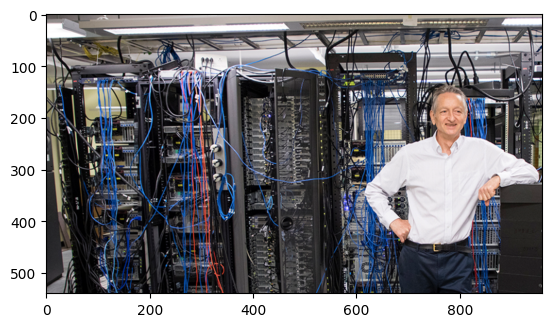

In [38]:
img_path='jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image = image.resize((int(half * image.size[0]), int(half * image.size[1])))

plt.imshow(image)
plt.show()

Create a transform object to convert the image to a tensor.

In [39]:
transform = transforms.Compose([transforms.ToTensor()])

Convert the image to a tensor.

In [40]:
img = transform(image)

Make a prediction, the output is a dictionary with several predicted classes, the probability of belonging to that class and the coordinates of the bounding box corresponding to that class.


In [41]:
pred = model([img])

<b>note</b>: Can call <code>model_([img])</code> directly but it will use more RAM 


35 different class predictions, ordered by likelihood scores for potential objects.


In [42]:
pred[0]['labels']

tensor([ 1,  2,  7, 62, 15, 84, 84, 35, 84, 82, 84, 35,  7, 82,  2,  2, 84,  7,
         2, 35,  9, 84, 15, 84, 62, 15, 84, 62,  7,  2, 84,  5, 42, 35, 84, 84,
         2,  7, 84])

Here is the likelihood of each class:


In [43]:
pred[0]['scores']

tensor([0.9996, 0.2425, 0.2117, 0.2012, 0.1824, 0.1703, 0.1683, 0.1466, 0.1373,
        0.1333, 0.1268, 0.1222, 0.1214, 0.1177, 0.1107, 0.1026, 0.0999, 0.0907,
        0.0903, 0.0896, 0.0879, 0.0868, 0.0835, 0.0775, 0.0764, 0.0724, 0.0720,
        0.0716, 0.0688, 0.0671, 0.0668, 0.0655, 0.0624, 0.0598, 0.0587, 0.0584,
        0.0579, 0.0536, 0.0516])

*Note* here I use likelihood as a synonym for probability. Many neural networks output a probability of the output of being a specific class. Here the output is the confidence of prediction, so I use the term likelihood to distinguish between the two.


The class number corresponds to the index of the list with the corresponding category name

In [44]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

Coordinates of the bounding box: 

In [45]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[611.6966552734375, 150.3425750732422, 953.8084106445312, 538.4383544921875]

These components correspond to the top-left corner and bottom-right corner of the rectangle,more precisely:
<p>top (t),left (l),bottom(b),right (r)</p>
Should be rounded..

In [46]:
t,l,r,b=[round(x) for x in bounding_box]

Convert the tensor to an open CV array and plot an image with the box:

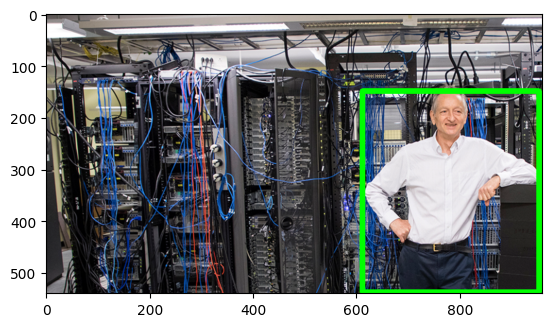

In [47]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

Localize objects using the function:
<code>get_predictions</code>. The input is the predictions <code>pred</code> and the <code>objects</code> to localize.

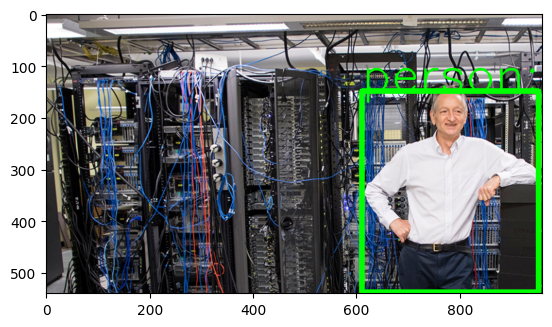

In [50]:
pred_class=get_predictions(pred,objects="person")
# Ensure coordinates are tuples of integers
pred_class = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_class]
draw_box(pred_class, img)
del pred_class

Set a threshold <code>threshold </code>. Here I set the threshold 1, i.e. 100% likelihood. 


In [51]:
get_predictions(pred,threshold=1,objects="person")

[]

Here we have no output as the likelihood is not 100%. Try a threshold of 0.98 and use the function draw_box to draw the box and plot the class and it's rounded likelihood.

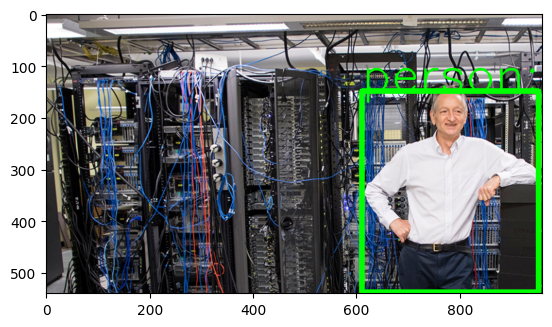

In [54]:
pred_thresh = get_predictions(pred, threshold=0.98, objects="person")
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img)
del pred_thresh

Delete objects to save memory, we will run this after every cell:


In [55]:
save_RAM(image_=True)

To locate multiple objects, consider the following <a href='https://www.kdnuggets.com/2015/03/talking-machine-deep-learning-gurus-p1.html'>image</a>, and try to detect the people in the image.

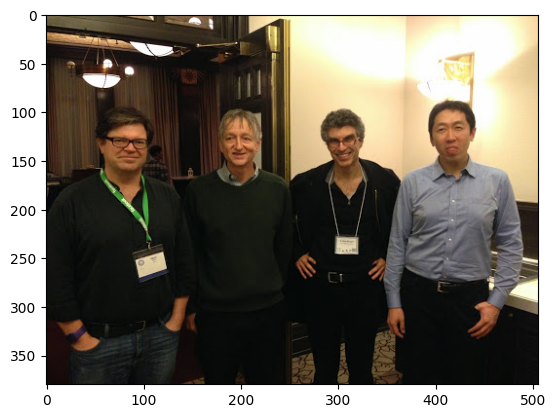

In [56]:
img_path='DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

Set a threshold to detect the object, 0.9 seems to work. As Andrew NG should be classified as 10% deity.  

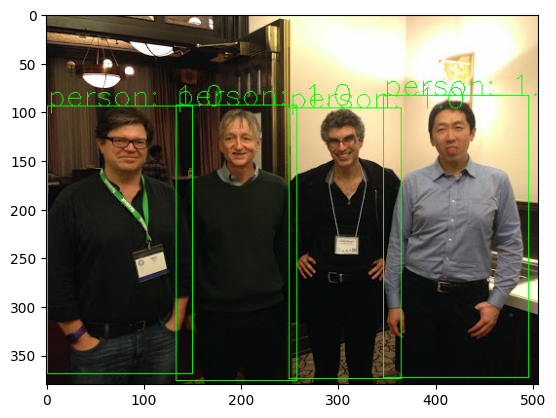

In [59]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.8)
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
del pred_thresh

Can also use objects parameter: 

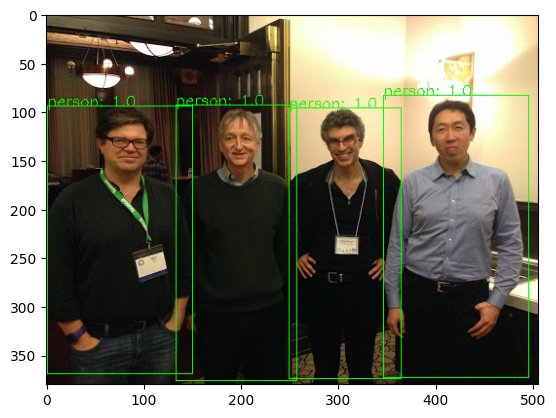

In [ ]:
pred_obj = get_predictions(pred, objects="person")
# Ensure coordinates are tuples of integers
pred_obj = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_obj]
draw_box(pred_obj, img, rect_th=1, text_size=0.5, text_th=1)
del pred_obj

Next i'll set the threshold too low, to see the implications. 

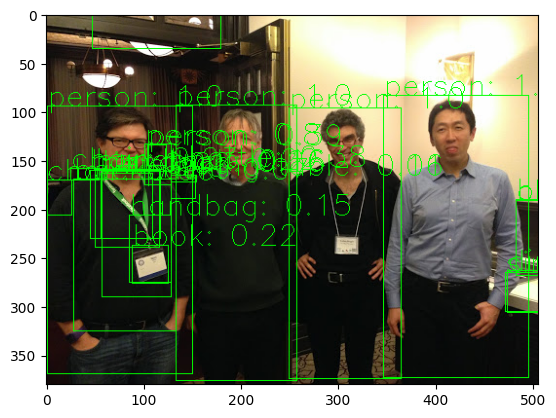

In [65]:
pred_thresh = get_predictions(pred, threshold=0.01)
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
del pred_thresh

Improve speed again by saving RAM.

In [66]:
save_RAM(image_=True)

## Object Detection 


In Object Detection we find the classes as well detect the objects in an image. Consider the following <a href="https://www.dreamstime.com/stock-image-golden-retriever-puppy-lying-parakeet-perched-its-head-weeks-old-next-to-british-shorthair-kitten-sitting-image30336051">image</a>


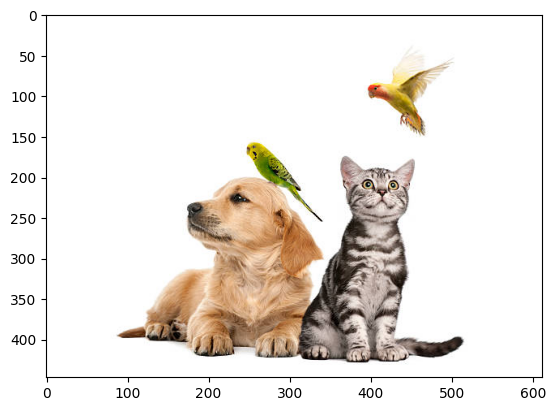

In [67]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

If we set a threshold, we can detect all objects whose likelihood is above that threshold.


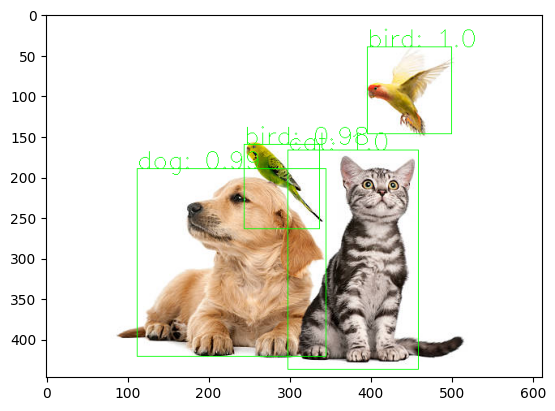

In [70]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.97)
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
del pred_thresh

Same approach to save RAM.

In [ ]:
save_RAM(image_=True)

We can specify the objects we would like to classify, for example, cats and dogs:


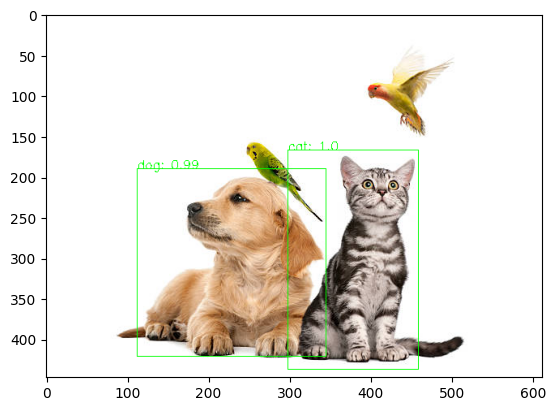

In [74]:
img_path='istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)
img = transform(image)
pred = model([img])
pred_obj = get_predictions(pred, objects=["dog", "cat"])
# Ensure coordinates are tuples of integers
pred_obj = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_obj]
draw_box(pred_obj, img, rect_th=1, text_size=0.5, text_th=1)
del pred_obj


In [75]:
# save_RAM()

If we set the threshold too low, we may detect objects with a low likelihood of being correct; here, we set the threshold to 0.7, and we incorrectly  detect a cat 


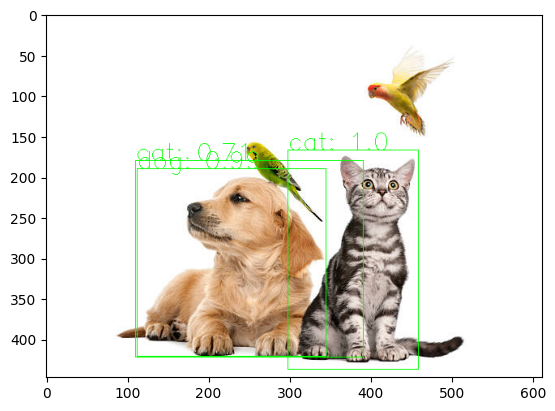

In [78]:
# img = transform(image)
# pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.70, objects=["dog", "cat"])
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
del pred_thresh

In [79]:
save_RAM(image_=True)


We can detect other objects. Consider the following <a href='https://www.flickr.com/photos/watts_photos/27581126637'>image</a>; We can detect cars and airplanes 


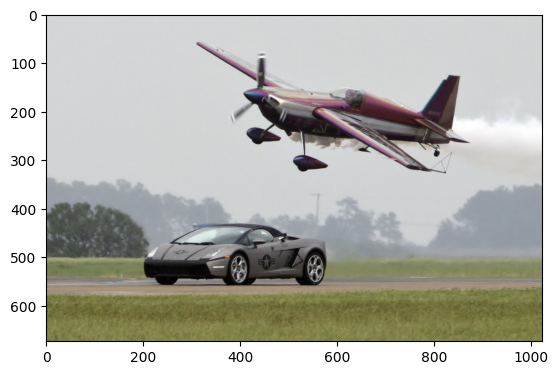

In [80]:
img_path='watts_photos2758112663727581126637_b5d4d192d4_b.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

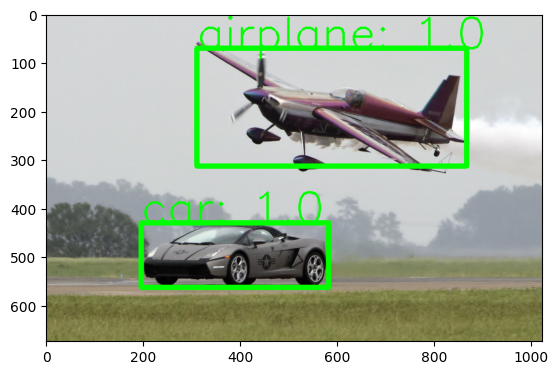

In [83]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.997)
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img)
del pred_thresh

In [84]:
save_RAM(image_=True)

## Test Model With An Uploaded Image


Here I will enter the url of an image and see if we can detect objects in it. Note: must be <code>jpg</code> or <code>png</code>.

In [85]:
url='https://www.plastform.ca/wp-content/themes/plastform/images/slider-image-2.jpg'

Perform a get request to download the image from the web and convert it to an RGB image. 

In [86]:
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
del url

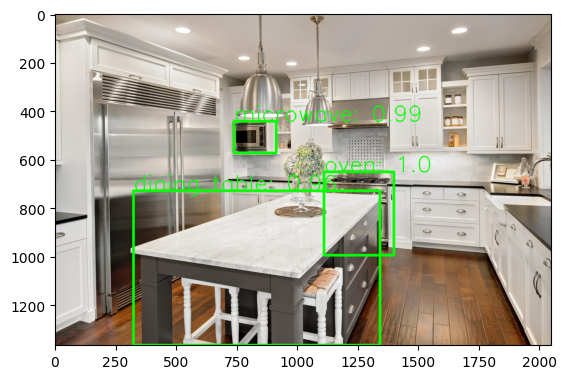

In [89]:
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.95)
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img)
del pred_thresh

In [90]:
save_RAM(image_=True)

Replace with the name of the image as seen in my directory


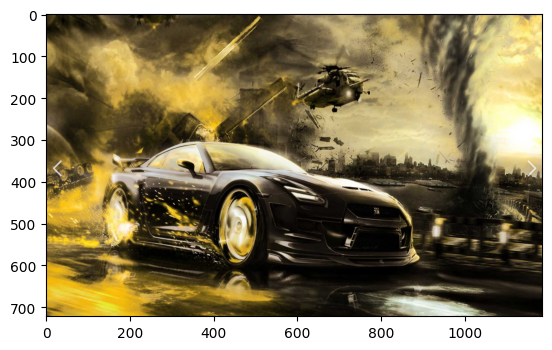

In [97]:
img_path='car_img_cnn_test.png'
image = Image.open(img_path) # Load the image
plt.imshow(np.array(image))
plt.show()

Detect objects

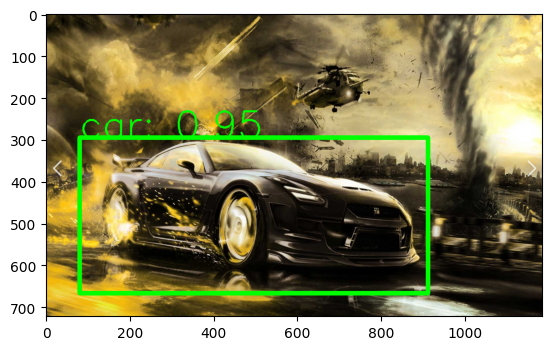

In [ ]:
if img.shape[1] == 4:  # Check if the image has an alpha channel
    img = img[:, :3, :, :]  # Remove the alpha channel

pred = model(img)
pred_thresh = get_predictions(pred, threshold=0.95)
# Ensure coordinates are tuples of integers
pred_thresh = [(name, prob, [(int(box[0][0]), int(box[0][1])), (int(box[1][0]), int(box[1][1]))]) for name, prob, box in pred_thresh]
draw_box(pred_thresh, img.squeeze(0))  # Squeeze to revert back to [C, H, W] for drawing

# Conclusion

In this notebook, we explored object detection using the Faster R-CNN model pre-trained on the COCO dataset. The key components and concepts covered were:

1. **Faster R-CNN Architecture**: We used a pre-trained Faster R-CNN model with a ResNet-50 backbone for accurate object detection.

2. **Key Functions and Processes**:
    - `get_predictions()`: Filtered object detection results based on confidence thresholds
    - `draw_box()`: Visualized detected objects with bounding boxes and labels
    - `model()`: Wrapped the Faster R-CNN model with memory optimization
    - `save_RAM()`: Managed memory efficiently for better performance

3. **Object Detection Capabilities**:
    - Object localization to find where objects are positioned in images
    - Multiple object detection within the same image
    - Class recognition across 91 different object categories
    - Confidence threshold tuning to balance precision and recall

4. **Business Applications**:
    - Retail inventory management and product recognition
    - Security and surveillance for detecting people or vehicles
    - Autonomous driving systems for detecting road users
    - Quality control in manufacturing to identify defects
    - Wildlife monitoring and conservation

5. **Model Performance Considerations**:
    - Threshold selection is crucial - too low leads to false positives, too high misses objects
    - The model performs well on common objects within the COCO dataset
    - Memory management is important for processing large images

This notebook demonstrated how deep learning models can effectively detect and classify objects in images with high confidence, enabling numerous real-world applications across industries.

# References 


[1]  Images were taken from: https://homepages.cae.wisc.edu/~ece533/images/
    
[2]  <a href='https://pillow.readthedocs.io/en/stable/index.html'>Pillow Docs</a>

[3]  <a href='https://opencv.org/'>Open CV</a>

[4] Gonzalez, Rafael C., and Richard E. Woods. "Digital image processing." (2017).


<!--<h2>Change Log</h2>-->


<!--<table>
    <tr>
        <th>Date (YYYY-MM-DD)</th>
        <th>Version</th>
        <th>Changed By</th>
        <th>Change Description</th>
    </tr>
    <tr>
        <td>2020-07-20</td>
        <td>0.2</td>
        <td>Joseph Santarcangelo </td>
        <td>Modified Multiple Areas</td>
    </tr>
    <tr>
        <td>2020-07-17</td>
        <td>0.1</td>
        <td>Azim</td>
        <td>Created Lab Template</td>
    </tr>
</table>
-->
